# Lab 8 - PyVision

The purpose of this lab is to help you become more familiar with:
* Exploratory Computing
* Python
* Jupyter notebooks
* The tiniest bit of Linux

That is a lot to bight off in 1.5 hours, so let's get started!

What to do:

Execute each of the cells in turn.  Do not skip any cells!

Everytime you execute a cell, you're changing the variable and function definitions change in the kernel, the brains of Python.  This lab is written such that if the cells above are correct and have been executed, the Python kernel should have what it needs to make the next cell work.

However, along the way, you will find cells which must be corrected in order to get everything to work properly!  These will be indicated with `PROBLEM` at the top and `FIXME` on the specific lines which require your attention.

## Imports

Let's start by executing the import cells below.

In [3]:
from time import sleep, time
from math import sin, cos, pi
import numpy as np
from scipy.ndimage.measurements import center_of_mass
from PIL import Image, ImageDraw
from IPython.display import clear_output, display

Additionally, we'll also need to modules for interacting with the hardware.  Let's load them as well if you are executing this code on the Raspberry Pi.  Otherwise you can skip them.

In [3]:
from picamera import PiCamera
from adafruit_servokit import ServoKit

The function below just helps convert a Numpy array into an image on the screen.  You need to execute the cell, but don't worry about how it works.

In [1]:
def displayArray(npArray, verbose=False):
    nDim = npArray.ndim
    dtype = npArray.dtype
    if verbose: print("nDim:",nDim," dtype:", dtype)
    if(nDim == 3 and dtype == np.uint8):
        (ny, nx, nc) = npArray.shape
        if nc != 3:
            print("8bit arrays with depth of 3 are expected to have three color channels")
            return
        else:
            display(Image.fromarray(npArray))
    elif(nDim == 2 and dtype == np.float_):
        if(np.min(npArray) < 0 or np.max(npArray > 1)):
            print("float array is not in range [0,1]")
            return
        else:
            lum8Bit = np.clip(256*npArray, 0, 255).astype('uint8')  # Rescales the image data to 'uint8' in range [0, 255]
            lum8BitRGB = np.dstack((lum8Bit, lum8Bit, lum8Bit))      # Turn it into RGB image.  The function np.dstack combines three 2D mxn arrays into one mxnx3 array.
            display(Image.fromarray(lum8BitRGB))

## Image Processing

### Images as Arrays

Computer images can come in a variety of formats, but the most common is that of a dense Red Green Blue (RGB) Array.  For an image which is $n+1$ pixels wide and $m+1$ pixels tall, this would look something like:
```
[[[r00, g00, b00], [r01, g01, b01], ... , [r0n, g0n, b0n]],
 [[r10, g10, b10], [r11, g11, b11], ... , [r1n, g1n, b1n]],
 ...
 [[rm0, gm0, bm0], [rm1, gm1, bm1], ... , [rmn, gmn, bmn]]]
 ```
 

Note that the $(0, 0)$ pixel is in the upper-left hand corner.  The pixels fill in the same way you would write words on the page: left-to-right, top-to-bottom.  Similar to matrices, we describe the size of such a matrix by starting at the outside and working our way in.  The size of the above array would be `(m+1, n+1, 3)`.  In other words, it is `m+1` pixels tall, `n+1` pixels wide, and has `3` color components.

Additionally, most computer monitors operate in 8-bit scale, meaning that the red value of a pixel can one of 256 values ranging from fully off (0) to fully on (255).  Why 256?  Because $2^8 = 256$.

A common strategy before dealing with messy real-world data, is to begin with simple well-understood data.  Before capturing and processing images from a camera, we're going to make our own.

Let us begin by creating an array of zeros representing an image which is {H,W} = {150, 200}.

In [4]:
testImageData = np.zeros(shape=(150, 200, 3), dtype=np.uint8)

We can visualize this data by converting it into an Image object.

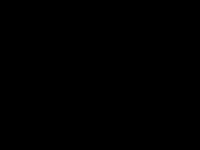

In [5]:
displayArray(testImageData)

We can use our Numpy indexing skills to alter this image.  For instance, let's put a red box in the middle.  

As a referesher, the snippet of code below can be interpretted as "for rows in the range [55, 95) and columns in the range [80, 120), change the RGB color value to [255, 0, 0].

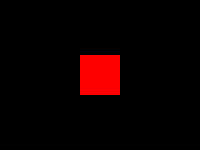

In [6]:
testImageData[55:95, 80:120] = [255, 0, 0]
displayArray(testImageData)

Ok... your turn!

* Put a blue box in the upper-left hand corner
* Put a green box in the lower-right hand corner
* Put a white box in the upper-right hand corner

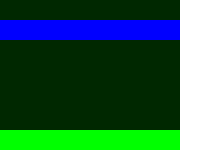

In [8]:
# Problem
testImageData = np.zeros(shape=(150, 200, 3), dtype=np.uint8)
testImageData[:, :] = [0, 40, 0]                   # Make the image black  FIXME
testImageData[20:40, 0:200] = [0, 0, 255]          # Blue box in upper-left corner FIXME
testImageData[130:150, 0:200] = [0, 255, 0]        # Green box in lower-right corner FIXME
testImageData[0:150, 180:200] = [255, 255, 255]    # White box in the upper-right corner FIXME
displayArray(testImageData)                        # Let's look at it.

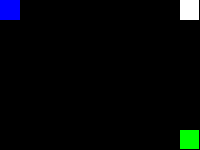

In [9]:
# SOLUTION
testImageData = np.zeros(shape=(150, 200, 3), dtype=np.uint8)
testImageData[:, :] = [0, 0, 0]                    # Make the image black
testImageData[0:20, 0:20] = [0, 0, 255]            # Blue box
testImageData[130:150-1, 180:200-1] = [0, 255, 0]  # Green box
testImageData[0:20, 180:200-1] = [255, 255, 255]   # White box
displayArray(testImageData)                        # Let's look at it.

The function below takes a numpy array and draws a circle of a given color and radius.  It returns a new array.

In [10]:
def colorCircle(imageData, rcCenter, rad, color):
    (nR, nC, _) = imageData.shape
    imageDataNew = imageData.copy()
    rCent, cCent = rcCenter
    for c in range(nC):                                                   # Loop over all columns
        for r in range(nR):                                               #   Loop over all rows
            if (r-rCent)**2 + (c-cCent)**2 < rad**2:                      #     If pixel is in circle
                imageDataNew[r, c] = color                                #       Set that pixel value to red.
    return imageDataNew


We're going to use it to add a red (`[255, 0, 0]`) circle centered on `(85, 110)`.  

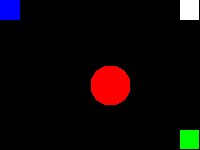

In [12]:
testImageDataDisk = colorCircle(testImageData, (85, 110), 20, [255, 0, 0])
displayArray(testImageDataDisk)

### Color Distance Computation

Let's see if we can look for only the red objects in the image.  We're going to do this by dividing the image up into three color channels (red, green, blue) and then calculating a color distance for each pixel.  We'll borrow the typical distance formula from geometry $d = \sqrt{((x_e - x_s)^2 + (y_e - y_s)^2 + (z_e - z_s)^2}$, but in this case, we'll use the colors as coordinates.

In [17]:
# PROBLEM
def computeColorDistance(rgbImageData, rgbTargetColor):
    rVal, gVal, bVal = rgbTargetColor                               # break the target color up into it's red, green, and blue values
    rCh = rgbImageData[:,:,0].astype('float')                       # separate the red channel from the image. (m,n) of 'float'.
    gCh = rgbImageData[:,:,1].astype('float')                       #              green
    bCh = rgbImageData[:,:,2].astype('float')                       #              blue
    rDisp = (rCh - rVal)/255.                                       # compute the "red displacement" and normalize to one.  (m,n) of 'float' in range [0, 1]
    gDisp = (gCh - gVal)/255.                                       #             "green displacement"
    bDisp = (bCh - bVal)/255.                                       #             "blue displacement"
    maxDist = ((1**2 + 1**2 + 1**2)**0.5)                           # The maximum possible distance assuming all three colors are 100% wrong
    colorDist = ((rDisp**2 + gDisp + bDisp**2)**0.5) / maxDist      # Compute the normalized distance.  (m, n) 'float' in range [0, 1]  FIXME
    return colorDist

In [14]:
# SOLUTION
def computeColorDistance(rgbImageData, rgbTargetColor):
    rVal, gVal, bVal = rgbTargetColor                               # break the target color up into it's red, green, and blue values
    rCh = rgbImageData[:,:,0].astype('float')                       # separate the red channel from the image. (m,n) of 'float'.
    gCh = rgbImageData[:,:,1].astype('float')                       #              green
    bCh = rgbImageData[:,:,2].astype('float')                       #              blue
    rDisp = (rCh - rVal)/255.                                       # compute the "red displacement" and normalize to one.  (m,n) of 'float' in range [0, 1]
    gDisp = (gCh - gVal)/255.                                       #             "green displacement"
    bDisp = (bCh - bVal)/255.                                       #             "blue displacement"
    maxDist = ((1**2 + 1**2 + 1**2)**0.5)                           # The maximum possible distance assuming all three colors are 100% wrong 
    colorDist = ((rDisp**2 + gDisp**2 + bDisp**2)**0.5) / maxDist   # Compute the normalized distance.  (m, n) 'float' in range [0, 1]  FIXME
    return colorDist

Code will often incorporate the idea of Unit Testing.  In Unit Testing, you test the code a small piece (typically a function) of the code for a handful of inputs/outputs that you can calculate and intuitively understand.  If enough of these simple tests behave as expected, then the unit (ie function) will likely also behave as expected.  If all of the functions behave as expected, then the code as a whole will behave as expected.

In traditional programming, these tests are often relegated to other files with complex automatic test runners.  However, in exploratory computing, it's nice to keep things simple just put them near the code it's testing.  This way you can use them for debugging.  Some people will actually write the tests first!

Let's check our color distance finder for several single pixel images.

In [18]:
whitePixel = np.array([255, 255, 255], 'uint8')
redPixel = np.array([255, 0, 0], 'uint8')
blackPixel = np.array([0, 0, 0], 'uint8')

print("Black to White color -> 1.0")
testImageDataUT = np.array([[blackPixel]], 'uint8')
dUT = computeColorDistance(testImageDataUT, whitePixel)
print("  got:", dUT)

print("White to White -> 0.0")
testImageDataUT = np.array([[whitePixel]], 'uint8')
dUT = computeColorDistance(testImageDataUT, whitePixel)
print("  got:", dUT)

print("Red to Red -> 0.0")
testImageDataUT = np.array([[redPixel]], 'uint8')
dUT = computeColorDistance(testImageDataUT, redPixel)
print("  got:", dUT)

print("Red to Black -> 1/sqrt(3) = 0.577")
testImageDataUT = np.array([[redPixel]], 'uint8')
dUT = computeColorDistance(testImageDataUT, blackPixel)
print("  got:", dUT)

Black to White color -> 1.0
  got: [[0.57735027]]
White to White -> 0.0
  got: [[0.]]
Red to Red -> 0.0
  got: [[0.]]
Red to Black -> 1/sqrt(3) = 0.577
  got: [[0.57735027]]


It's also good to test the code at a system level as we expect to use it.  Does the image make sense?

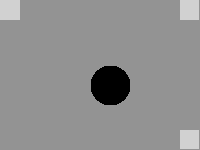

In [19]:
red = np.array([255, 0, 0], 'uint8')
distData = computeColorDistance(testImageDataDisk, red)
displayArray(distData)

### Binarization

We're going to want to "binarize" this distance data such that anything smaller than a certain "threshold" becomes one and anything greater becomes zero.  This is useful for creating an image "mask" for image processing which hightlights the regions where there distance error is considered small enough.

In [20]:
# PROBLEM
def thresholdBinarize(distData, threshold):
    maskData = np.where(distData < threshold, 0.3, 0.8) # FIXME
    return maskData

In [21]:
# SOLUTION
def thresholdBinarize(distData, threshold):
    maskData = np.where(distData < threshold, 1.0, 0.0) # FIXME
    return maskData

And let's test this function to make sure it is working as expected.

In [22]:
print("Expected: [[1., 1., 0., 0., 0.]]")
testData = np.array([[0., 0.25, 0.5, 0.75, 1.0]])
thresholdBinarize(testData, 0.4)

Expected: [[1., 1., 0., 0., 0.]]


array([[1., 1., 0., 0., 0.]])

Let's combine the two functions to see if we can isolate the red disk.  

In the code below, make sure we're searching for the correct color with tight
enough threshold.

<ipython-input-17-2bf51278700b>:11: RuntimeWarning: invalid value encountered in sqrt
  colorDist = ((rDisp**2 + gDisp + bDisp**2)**0.5) / maxDist      # Compute the normalized distance.  (m, n) 'float' in range [0, 1]  FIXME


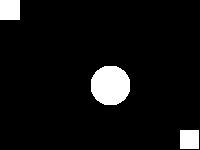

In [32]:
# PROBLEM 
red = np.array([0, 255, 0], 'uint8')                    # FIXME
distData = computeColorDistance(testImageDataDisk, red)
binData = thresholdBinarize(distData, 0.65)             # FIXME
displayArray(binData)

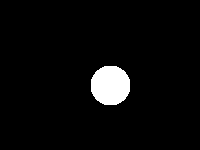

In [33]:
# SOLUTION 
red = np.array([255, 0, 0], 'uint8')                    # FIXME
distData = computeColorDistance(testImageDataDisk, red)
binData = thresholdBinarize(distData, 0.1)             # FIXME
displayArray(binData)

### Dimming an Image Using a Mask

We can do cool things by combing the mask with an image.  For instance, we can use the mask to dim all of the part of the image which are not selected.  Again, we do this by manipulating the arrays.

We want scale factor function such that `SF(0) -> dimFactor` and `SF(1) -> 1`.  Then when we multiply this array by the image data, all of the unselected pixels (the zeros) will be driven to a maximum brightness of `dimFactor`.  By inspection, we see that `SF(m) = (m)*1 + (1 - m)*dimFactor` has these properties.

In [34]:
def imageDimmer(imageData, mask, dimFactor):
    maskF = mask.astype('float')
    scalingImageData = (1 - maskF)*dimFactor + maskF
    dimmedImageData = (imageData * np.atleast_3d(scalingImageData)).astype('uint8')
    return dimmedImageData

As a quick test, consider two white pixels and a mask that "selects" the first one.  Note that the processed image dimmed the second pixel to about 25% of its original value.

In [35]:
whitePixel = np.array([255,255,255], "uint8")
testData = np.array([[ whitePixel, whitePixel ]])
mask = np.array([[1, 0]])
imageDimmer(testData, mask, 0.25)

array([[[255, 255, 255],
        [ 63,  63,  63]]], dtype=uint8)

Let's now add that in.

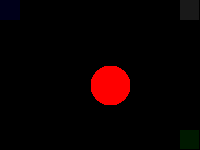

In [36]:
red = np.array([255, 0, 0], 'uint8')
distData = computeColorDistance(testImageDataDisk, red)
maskData = thresholdBinarize(distData, 0.2)
dimmedImage = imageDimmer(testImageDataDisk, maskData, 0.1)
displayArray(dimmedImage)

### Center-of-Mass Calcuation

We're also going to need a method of determining the "center of mass" of a binary image.  We could implement our own, but the beauty of Python is the amount of existing libraries out there.  Let's use SciPy's `center_of_mass` function.  Consider the binary image below.  Does these results make sense?  Remember, that Python counts with zero-indexing.

In [37]:
testData = np.array([[0, 0, 1, 1, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0]])
center_of_mass(testData) # (row, column)

(0.0, 3.0)

Alter the array in testData such that the center of mass is at `(0.5, 3.5)'

In [ ]:
# PROBLEM
testData = np.array([[0, 0, 1, 1, 1, 0, 0, 0, 0],   # FIXME
                     [0, 0, 0, 0, 0, 0, 0, 0, 0]])  # FIXME
center_of_mass(testData) # (row, column)

In [40]:
# SOLUTION
testData = np.array([[0, 0, 1, 1, 1, 1, 0, 0, 0],
                     [0, 0, 1, 1, 1, 1, 0, 0, 0]])
center_of_mass(testData) # (row, column)

(0.5, 3.5)

Finally, let us now use `maskData`, which was `1` in the red circle and `0` 
elsewhere to determine the center of mass of the red circle.  Is this where we
put it?

In [41]:
red = np.array([255, 0, 0], 'uint8')
distData = computeColorDistance(testImageDataDisk, red)
maskData = thresholdBinarize(distData, 0.2)
center_of_mass(maskData)

(85.0, 110.0)

### Combining Everything into a Function

Now that we've explored and tested each of the components, let's pull it all together.  This is called "encapsulation."  It allows us to easily make use of the code.

Copy and paste the appropriate lines above to build a function which:
* finds an object in an image by color
* computes where it is
* displays a "dimmed image" that has the CoM highlighted by a green dot.

In [45]:
# PROBLEM
# def ImageTracker(testImageData, targetColor, threshold, dimFactor):
#     distData = # FIXME
#     maskData = # FIXME
#     dimmedImage = # FIXME
#     displayArray()# FIXME
#     (rCoM, cCoM) = center_of_mass(maskData)
#     return (rCoM, cCoM)

In [46]:
#SOLUTION
def ImageTracker(testImageData, targetColor, threshold, dimFactor, printImage=True):
    distData = computeColorDistance(testImageData, targetColor)
    maskData = thresholdBinarize(distData, threshold)
    dimmedImage = imageDimmer(testImageData, maskData, dimFactor)
    (rCoM, cCoM) = center_of_mass(maskData)
    dimmedImage = colorCircle(dimmedImage, (rCoM, cCoM), 3, [0, 255, 0])
    if printImage: displayArray(dimmedImage)
    return (rCoM, cCoM)

And let's test it on our image.

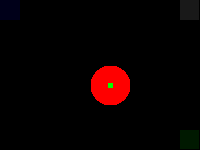

(85.0, 110.0)

In [47]:
ImageTracker(testImageDataDisk, targetColor=[255, 0, 0], threshold=0.2, dimFactor=0.1)

Real-world data is messy.  How does this work on a actual photograph?

Use the cell below if you are running this notebook on Colab.  Otherwise if `baboon.png` is locally available, use the next cell.

In [ ]:
import requests
from io import BytesIO

baboonPath = "https://cms.uni-konstanz.de/fileadmin/archive/informatik-saupe/fileadmin/informatik/ag-saupe/Webpages/lehre/dip_w0910/pictures/baboon.png"
response = requests.get(baboonPath)
baboonImageData = np.array(Image.open(BytesIO(response.content)))
displayArray(baboonImageData)

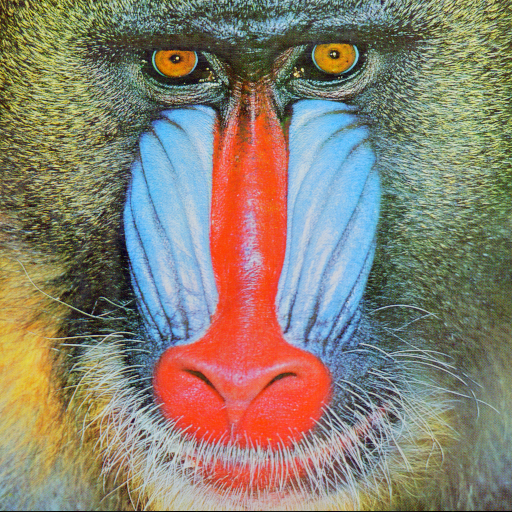

In [48]:
baboonImageData = np.array(Image.open('baboon.png'))
displayArray(baboonImageData)

Adjust the settings below to find the center of the baboon's nose.  Because this is "real world data," things won't be perfect, but it can be basically working.

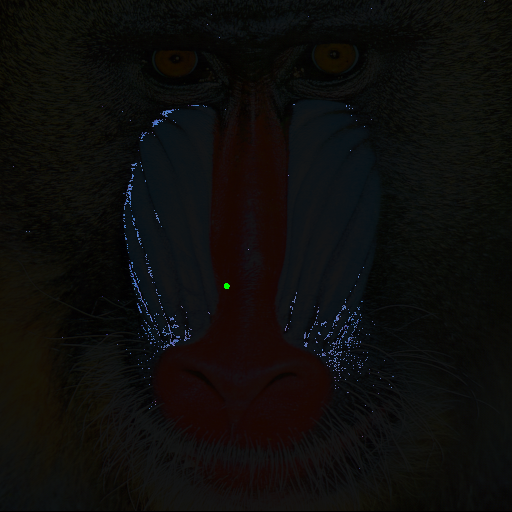

(285.73646496815286, 226.1544585987261)

In [49]:
# PROBLEM
ImageTracker(baboonImageData, targetColor=[100, 100, 255], threshold=0.25, dimFactor=0.1) # FIXME

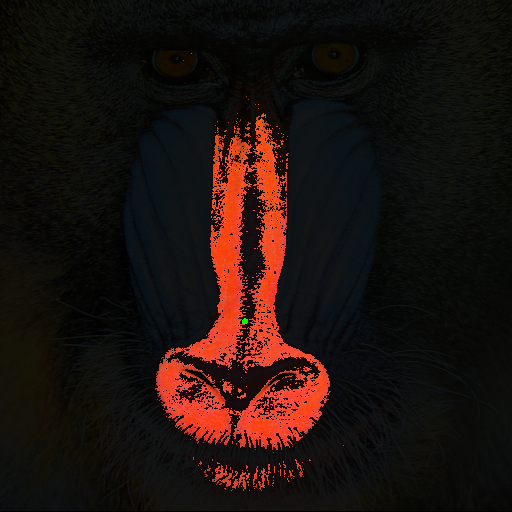

(320.778766880785, 244.69025340144657)

In [53]:
# SOLUTION
ImageTracker(baboonImageData, targetColor=[255, 30, 30], threshold=0.3, dimFactor=0.1)

# Image Capture

Good!  We've developed a lot of great tools and bundled it together into a function.  Now we can apply it to live data coming from the camera.

We need a place to put the data.  A Numpy array is particularly well suited for this because it is a dense array.  If it is the proper shape, the data can be directly written there.  The numpy array must match the size of the incoming array exactly, or else weird things happen.  Note that this is a color camera, so each pixel has an RGB (Red, Green, Blue) value.

In [55]:
(nCols, nRows) = (160, 128)                                           # Choose the size of the camera collection
imageData = np.zeros(shape=(nRows, nCols, 3), dtype='uint8')          # Create a location in RAM to put the data.

Next, we're going to create the camera object and then we're going to change some of its attributes.

In [56]:
try:
    cam = PiCamera()
except:
    pass

cam.resolution = (nCols, nRows)                                       # Set the camera resolution
cam.framerate = 10                                                    # Framerate
cam.rotation = 180                                                    # Rotation (depending on mounting, this could be either 0 or 180)

NameError: name 'cam' is not defined

A key thing that I want to make clear is that all the `cam.capture(imageData, 'rgb')` does is change the data in the numpy array `imageData`.  Additionally `imageData` is no different the other `(m,n,3)` Numpy arrays that we've been working on.  There is no magic here.

This is very intentional.  Our previous image processing work and the image capture share the same *interface*.

Let's use the camera to change the data in `imageData` and display it.  Execute the cell below as many times as you wish.

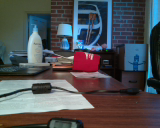

In [34]:
cam.capture(imageData, 'rgb')
displayArray(imageData)

# Moving the Servos

In [35]:
from adafruit_servokit import ServoKit
servoBoard = ServoKit(channels=16)

In [36]:
tiltServo = servoBoard.servo[0]  # Moves up and down.  The `0` here means the servo is plugged into the first slot on the control board.
panServo = servoBoard.servo[1]   # Moves left and right.  The `1` here means the servo is plugged into the second slot on the control board.

The two servos both have ranges of [0, 180].  Play with this.  See what happens when you punch in different values.

In [100]:
tiltServo.angle = 80.0
panServo.angle = 100.0

In [101]:
tiltServo.angle = 90.0
panServo.angle = 90.0

Can we make them move in a circle?

In [102]:
# PROBLEM
for deg in range(360):
    panServo.angle = 90 + 30*sin(deg*pi/180)       # FIXME
    tiltServo.angle = 90 + 10*sin(deg*pi/180)      # FIXME
    sleep(0.01)                             # Pauses for 0.01 seconds before moving onto next step.

tiltServo.angle = 90.0                      # Return to center.
panServo.angle = 90.0

In [104]:
# SOLUTION
for deg in range(360):
    panServo.angle = 60 + 30*cos(deg*pi/180)        # FIXME
    tiltServo.angle = 90 + 30*sin(deg*pi/180)       # FIXME
    sleep(0.01)                                     # Pauses for 0.01 seconds before moving onto next step.

tiltServo.angle = 90.0                      # Return to center.
panServo.angle = 90.0

Just for fun, let's give it a bunch of small random deflections.

In [105]:
start = time()
while(time() - start < 3):
    panServo.angle = 0.1*np.random.normal() + panServo.angle
    tiltServo.angle = 0.1*np.random.normal() + tiltServo.angle

tiltServo.angle = 90.0                      # Return to center.
panServo.angle = 90.0

# Putting it all together

The goal of this last stage is to get the camera, image processing, and servos working together so that the camera follows an object around.

First we're going to begin by capturing an image and attempting to process it to find the target object.  Tweak the `targetColor`, and `threshold` until you feel like your code is doing a good job of selecting for the target object.

As a general strategy, begin with a higher threshold and lower it as you dial in the target color.

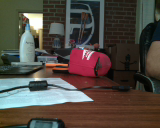

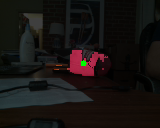

(62.92918825561313, 83.01899827288429)


In [89]:
targetColor = [180, 20, 20]            # FIXME
threshold = 0.15                       # FIXME
cam.capture(imageData, 'rgb')
displayArray(imageData)
(rCoM, cCoM) = ImageTracker(imageData, targetColor=targetColor, threshold=threshold, dimFactor=0.25)
print((rCoM, cCoM))

Your target likely isn't at the center of the image.  We can use "negative feedback" to adjust the servos to point the camera at the target.  The term "negative feedback" means that we measure the error and we attempt to negate it by going the other way.  Our error is going to come in the form of how far the center-of-mass is from the center of the image.  We'll convert the error into a servo adjustment by way of a "feedback coefficient."  The trick is adjust this term such that:
* we're correcting in the right direction (the sign must feedback coeffient must be correct) or we make things worse!
* it isn't too large (we could "over-correct" leading to oscilliatory behavior)
* it isn't too small (we won't be able to keep up with the target.)

Play with the feedback coefficients below until every time you execute the cell, it moves the camera to almost center the target.

In [90]:
tiltServo.angle = 90.0                      # Return to center.
panServo.angle = 90.0

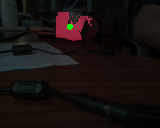

In [91]:
# PROBLEM
def ObserveAndAdjust(targetColor, threshold):
    (fbcCol, fbcRow) = (0.00, 0.00)  # FIXME
    cam.capture(imageData, 'rgb')
    (rCoM, cCoM) = ImageTracker(imageData, targetColor, threshold, dimFactor=0.25)
    (rowCent, colCent) = (nRows/2, nCols/2)
    errorPan = (cCoM - colCent)
    errorTilt = (rCoM - rowCent)
    panServo.angle += fbcCol*errorPan
    tiltServo.angle += fbcRow*errorTilt

ObserveAndAdjust(targetColor, threshold)

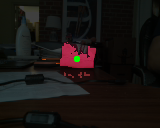

In [96]:
# SOLUTION
def ObserveAndAdjust(targetColor, threshold):
    (fbcCol, fbcRow) = (0.4, -0.4)
    cam.capture(imageData, 'rgb')
    (rCoM, cCoM) = ImageTracker(imageData, targetColor, threshold, dimFactor=0.25)
    (rowCent, colCent) = (nRows/2, nCols/2)
    errorPan = (cCoM - colCent)
    errorTilt = (rCoM - rowCent)
    panServo.angle += fbcCol*errorPan
    tiltServo.angle += fbcRow*errorTilt

ObserveAndAdjust(targetColor, threshold)

And now let's make it work continuously for 30 seconds.  

Tip: It will look better if there are no cells under it.  Rather than hitting "shift-enter", press the play button to the left of the cell.  This won't automatically create another cell below.

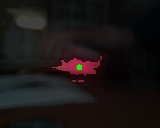

In [95]:
start = time()
while(time() - start < 30):
    clear_output(wait=True)
    ObserveAndAdjust(targetColor, threshold)